In [ ]:
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from preprocess import wav_to_mel
from synthesis import load_hifigan_model, synthesize
from models.vqgan.spectrogram_vq import SpectrogramVQ


AUDIO_ID = "LJ001-0012" # Please set the AUDIO_ID here

parser = argparse.ArgumentParser()
parser.add_argument('--latent_dim', type=int, default=128, help='Dimension of latent vectors')
parser.add_argument('--num_codebook_vectors', type=int, default=128, help='Number of codebook vectors')
parser.add_argument('--beta', type=float, default=0.25, help='Commitment loss weight')
parser.add_argument('--hifigan-config-path', type=str, default="/workspace/tts/DCTTS/models/hifigan/config.json", help='Path to HiFi-GAN config')
parser.add_argument('--hifigan-ckpt-path', type=str, default="/workspace/tts/DCTTS/models/hifigan/generator_LJSpeech.pth.tar", help='Path to HiFi-GAN checkpoint')
parser.add_argument('--spectrogram-vq-ckpt-path', type=str, default="/workspace/tts/DCTTS/checkpoints/spectrogram_vq_epoch_69.pt", help='Path to Spectrogram VQGAN checkpoint')
args = parser.parse_args([])

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SpectrogramVQ(args)
state_dict = torch.load(args.spectrogram_vq_ckpt_path)
model.load_state_dict(state_dict['spectrogram_vq_state_dict'])
model.to(device).eval()

hifigan = load_hifigan_model(args.hifigan_config_path, args.hifigan_ckpt_path, device)
hifigan.to(device).eval()

Generator(
  (conv_pre): ParametrizedConv1d(
    80, 512, kernel_size=(7,), stride=(1,), padding=(3,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _WeightNorm()
      )
    )
  )
  (ups): ModuleList(
    (0): ParametrizedConvTranspose1d(
      512, 256, kernel_size=(16,), stride=(8,), padding=(4,)
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _WeightNorm()
        )
      )
    )
    (1): ParametrizedConvTranspose1d(
      256, 128, kernel_size=(16,), stride=(8,), padding=(4,)
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _WeightNorm()
        )
      )
    )
    (2): ParametrizedConvTranspose1d(
      128, 64, kernel_size=(4,), stride=(2,), padding=(1,)
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _WeightNorm()
        )
      )
    )
    (3): ParametrizedConvTranspose1d(
      64, 32, kernel_size=(4,), stri

In [15]:
sample_audio_path = f"/workspace/data/wavs/{AUDIO_ID}.wav"

mel = wav_to_mel(sample_audio_path)
mel = torch.from_numpy(mel).unsqueeze(0).to(device)
if mel.shape[2] % 2 == 1:
    mel = F.pad(mel, (0,1), "constant", 0)

with torch.no_grad():
    indices = model.encode(mel.unsqueeze(0))
    reconstructed_mel = model.decode(indices)
    reconstructed_wav = synthesize(hifigan, reconstructed_mel[0], f"./recon_{AUDIO_ID}.wav")

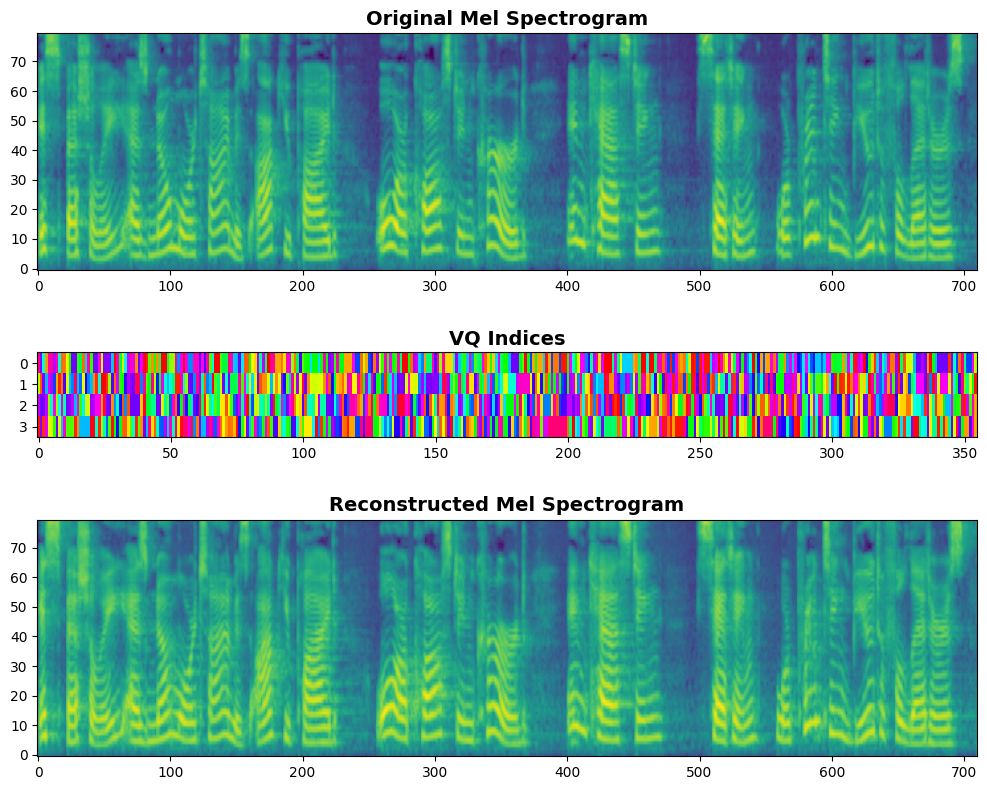

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
axs[0].imshow(mel[0].cpu().numpy(), aspect='auto', origin='lower')
axs[0].set_title('Original Mel Spectrogram', fontsize=14, fontweight='semibold')
axs[1].imshow(indices[0].cpu().numpy(), aspect='auto', interpolation='none', cmap='hsv')
axs[1].set_aspect(8.0)
axs[1].set_yticks(np.arange(indices.shape[1]))
axs[1].set_title('VQ Indices', fontsize=14, fontweight='semibold')
axs[2].imshow(reconstructed_mel[0].squeeze().cpu().numpy(), aspect='auto', origin='lower')
axs[2].set_title('Reconstructed Mel Spectrogram', fontsize=14, fontweight='semibold')
plt.tight_layout()
plt.show()

In [17]:
from IPython.display import Audio

print("Original Audio")
display(Audio(sample_audio_path))

print("Reconstructed Audio")
display(Audio(reconstructed_wav, rate=22050))

Original Audio


Reconstructed Audio


In [18]:
print("Indices.shape:", indices[0].shape)
print(indices[0])

Indices.shape: torch.Size([4, 355])
tensor([[116,  96,  62,  ...,  80, 108,  28],
        [ 28,   8,  97,  ...,  24,  45,   3],
        [102,  95,  95,  ...,  39, 111,  15],
        [  3,  97,   5,  ...,  93, 111,  15]], device='cuda:0')
